# Traffic Flow Data Analysis

En esta hoja se hará un análisis inicial de los datos
provenientes de las mediciones de los sensores proporcionadas por el
ayuntamiento de la ciudad de Santiago de Compostela.

En primer lugar hay que hacer los imports necesarios:

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from math import ceil
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Se realiza la carga del fichero .csv que contiene los datos:

In [3]:
csv_path = "data/2_Oct2019.csv"
df = pd.read_csv(csv_path)


Ahora vamos a ver cómo son los datos y los trataremos un poco:

In [4]:
df.head()

df.pop('speed')
df.pop('FID')

df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%dT%H:%M:%S')

df['car_count'] = df['flow']/12

df.sample()

,_id,sensor,flow,datetime,car_count
118891,118892,PM047,144,2019-10-06 16:10:00,12.0


Acciones realizadas:
1. La columna `speed` no aporta nada, todos su valores son -9999
2. La columna `FID` tampoco, es un identificador de cada medición, al igual que `_id`
3. La columna `datetime` tuvo que ser formateada para obtener un formato válido
4. La columna `flow` dividida por 12 representa el número de vehículos que pasaron sobre
ese sensor en los últimos 5 minutos -> `car_count`

Veamos algunas estadísticas del conjunto de datos:

In [5]:
df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
_id,623329.0,311665.000000,179939.727309,1.0,155833.0,311665.0,467497.0,623329.00
flow,623329.0,155.970730,328.490928,0.0,0.0,60.0,252.0,99999.00
car_count,623329.0,12.997561,27.374244,0.0,0.0,5.0,21.0,8333.25


El max de `flow` y por ende el de `car_count` no parece un número muy normal, y menos
tratándose de una ciudad como Santiago de Compostela, dónde es imposible que circulen 8333
vehículos sobre un sensor en 5 minutos. Es necesario arreglar este outlayer:

(TODO: PONER LA MEDIA ENTRE LOS 5 MIN MIN ANTERIORES Y LOS 5 MINUTOS SIGUIENTES)

In [6]:
flow = df['flow']
bad_max_flow = flow == flow.max()
flow[bad_max_flow] = 0.0

count = df['car_count']
bad_max_count = count == count.max()
count[bad_max_count] = 0.0

<ipython-input-6-19bb781830b5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flow[bad_max_flow] = 0.0
<ipython-input-6-19bb781830b5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  count[bad_max_count] = 0.0


In [7]:
df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
_id,623329.0,311665.000000,179939.727309,1.0,155833.0,311665.0,467497.0,623329.0
flow,623329.0,155.329020,209.608361,0.0,0.0,60.0,252.0,7908.0
car_count,623329.0,12.944085,17.467363,0.0,0.0,5.0,21.0,659.0


Parece que ahora tiene algo más de sentido.

Veamos la evolución del tráfico a lo largo de este mes en un sensor relevante.
El sensor escogido es el `PM072`, el que monitoriza el tráfico que entra en la rotonda
del CITIUS:


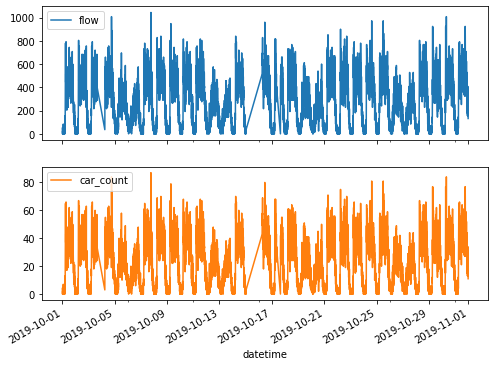

In [8]:
# Filas del sensor PM072
PM072_data = df.loc[df['sensor'] == 'PM072']

#Timestamps de los mediciones
date_time = PM072_data['datetime']

plot_cols = ['flow', 'car_count']
plot_features = PM072_data[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

La siguiente función recibe el nombre de un sensor, una lista de días y el dataset. Grafica
la información recopilada por ese sensor durante esos días.

In [110]:
def plot_sensors_daily_data(sensor, daylist, df_orig):

    df = df_orig.loc[df_orig['sensor'] == sensor]

    fig, axs = plt.subplots(daylist.shape[0], figsize=(15,15))
    fig.tight_layout(pad=5.0)
    fig.suptitle('Data Sensor ' + sensor, fontsize=16)

    for i in range(daylist.shape[0]):
        x = df.loc[(df['datetime'] >= daylist[i]) & (df['datetime'] <= daylist[i]+datetime.timedelta(days=1)), 'datetime']
        y = df.loc[(df['datetime'] >= daylist[i]) & (df['datetime'] <= daylist[i]+datetime.timedelta(days=1)), 'car_count']

        myFmt = mdates.DateFormatter('%H:%M')
        axs[i].xaxis.set_major_formatter(myFmt)
        axs[i].set(xlabel='Hours', ylabel='Car count')
        axs[i].set_title('Day: '+ daylist[i].strftime("%Y-%m-%d (%A)"))

        axs[i].plot(x, y)

Podemos probar a pasarle los 7 días de una semana para ver como evoluciona el tráfico que pasa
por ese sensor durante esa semana:

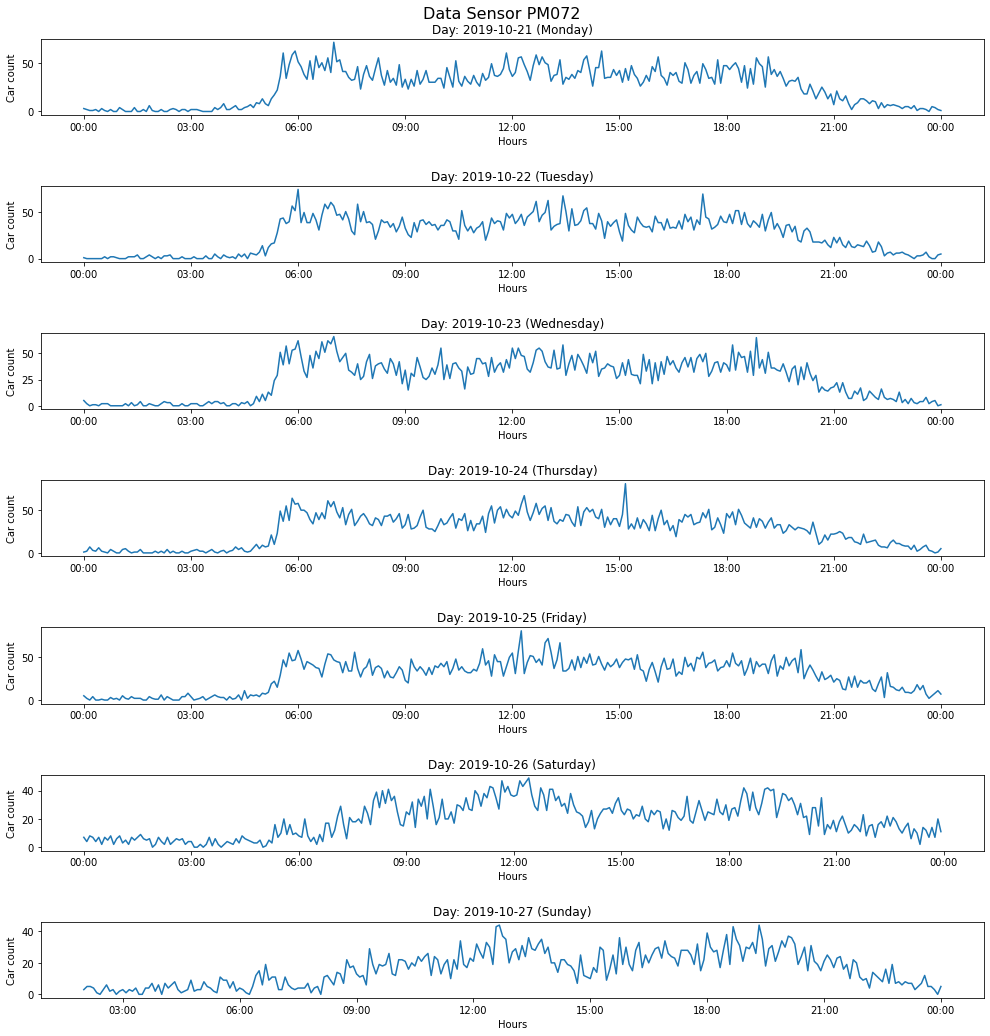

In [95]:
days = pd.date_range(start='2019-10-21', end='2019-10-27', freq='D')
plot_sensors_daily_data(sensor='PM072', daylist = days, df_orig=df)

También podemos graficar los lunes (o cualquier día de la semana: W-SUN, W-FRI) que hubo en un mes:

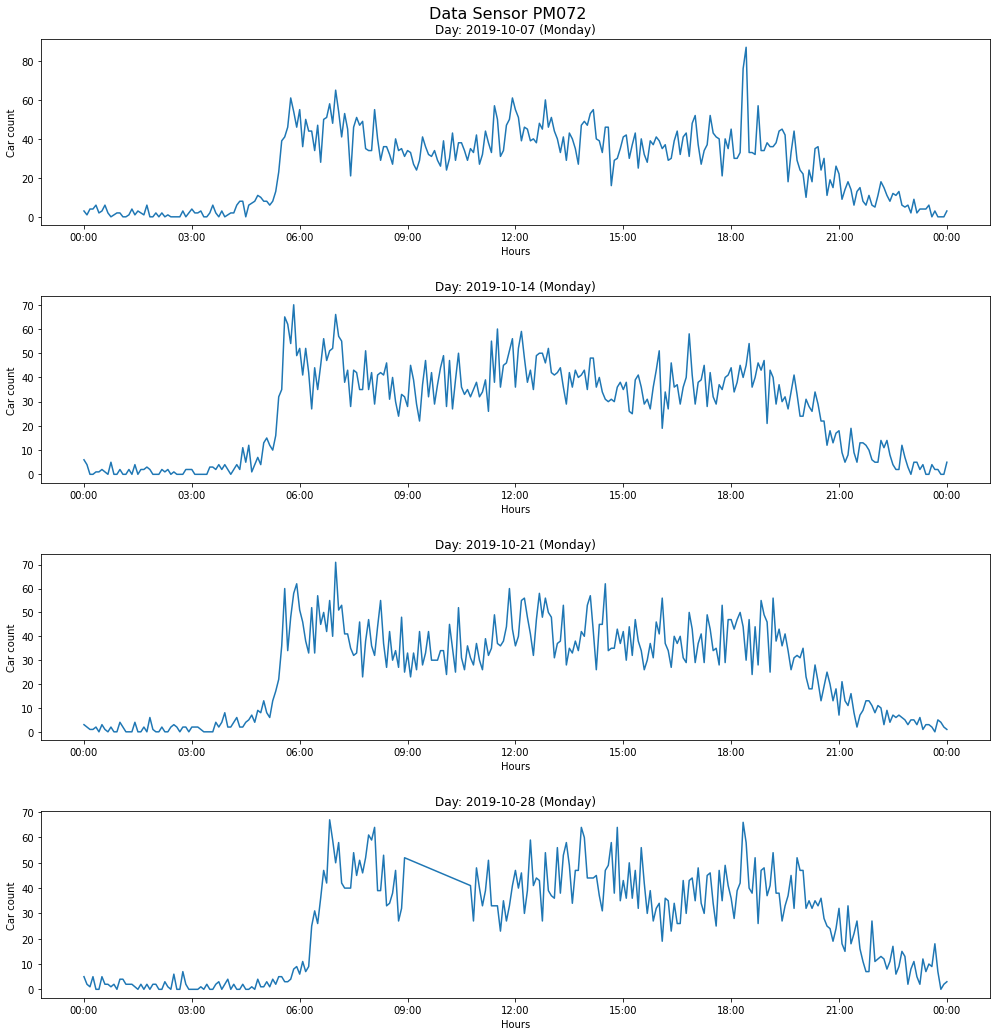

In [102]:
days = pd.date_range(start='2019-10-01', end='2019-10-31', freq='W-MON')
plot_sensors_daily_data(sensor='PM072', daylist = days, df_orig=df)



## Correlación entradas en rotondas y punto a predecir

También es interesante ver la correlación entre el número de coches que entran en las rotonas y
el número de coches que sale por el punto a predecir.

El punto a predecir (CITIUS) es el sensor`PM072`
1. Los sensores de entrada a la rotonda do Camiño Novo son: `PM030`, `PM031`, `PM032` y `PM033`
2. Los de salida son: `PM024` y `PM034`
3. Hacia Rosalía de Castro no hay sensor. Hay uno a la altura de Boel: `PM035`, pero perdemos el tráfico que va
hacia la Plaza de Vigo y cuenta los que vienen de la misma. En la Avenida de Villagarcía hay un sensor (`PM025`) que podría usarse para compensar la
pérdida del sensor de Boel, pero es peligroso, ya que cuenta también los coches que vienen de Rosalía de Castro
(en sentido rotonda), los de Santiago de Chile y perdemos los que van en sentido Plaza Roja.

Por otra parte, en la rotonda de la Galuresa tenemos:
1. De entrada: `PM076`, `PM077` y `PM079`
2. De salida: `PM016` (Perdemos los coches que entran en la estación de tren) y
`PM020` (Perdemos los coches que van por Santiago de Chile)